In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from arch import arch_model

In [2]:
df = pd.read_csv('../data/raw_data/gspc.csv', index_col='date')
df.index = pd.to_datetime(df.index)

In [3]:
print(df.head(5))
print(df.info())

                        close               high                low  \
date                                                                  
NaT                     ^GSPC              ^GSPC              ^GSPC   
2020-01-02   3257.85009765625  3258.139892578125  3235.530029296875   
2020-01-03   3234.85009765625   3246.14990234375  3222.340087890625   
2020-01-06  3246.280029296875  3246.840087890625  3214.639892578125   
2020-01-07  3237.179931640625  3244.909912109375  3232.429931640625   

                         open      volume  
date                                       
NaT                     ^GSPC       ^GSPC  
2020-01-02     3244.669921875  3459930000  
2020-01-03  3226.360107421875  3484700000  
2020-01-06  3217.550048828125  3702460000  
2020-01-07  3241.860107421875  3435910000  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, NaT to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   

In [4]:
print(f'Duplicates in the data: {df.duplicated().sum()}')
print(f'Missing values in the data: {df.isnull().sum()}')

Duplicates in the data: 0
Missing values in the data: close     0
high      0
low       0
open      0
volume    0
dtype: int64


In [5]:
df = df.drop(df.index[0])

In [6]:
df = df.astype(float)

In [7]:
n = len(df)
print(f'Len data: {n}')
bins = int(np.sqrt(n))
print(f'Bins: {bins}')

Len data: 1258
Bins: 35


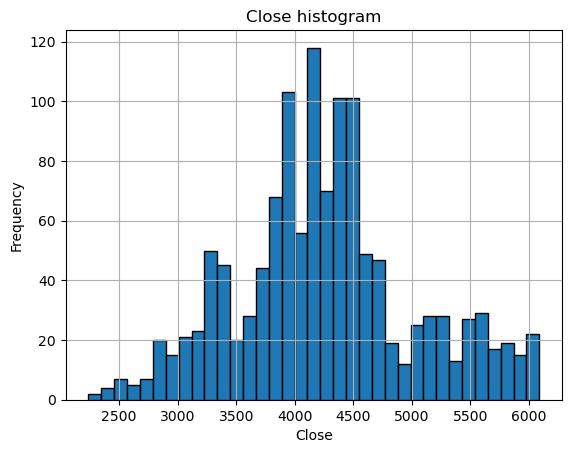

In [8]:
df['close'].hist(bins=bins, edgecolor='black')
plt.title('Close histogram')
plt.xlabel('Close')
plt.ylabel('Frequency')
plt.show()

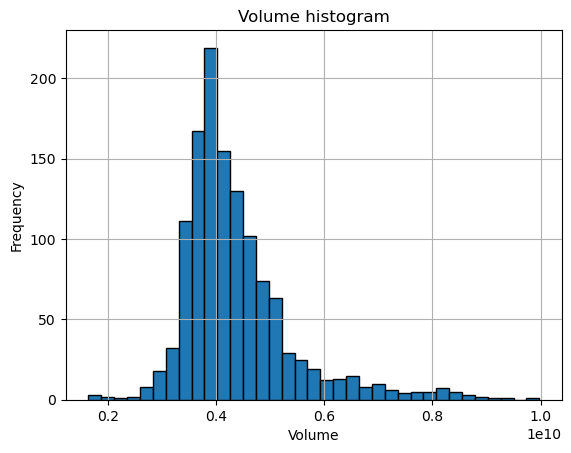

In [9]:
df['volume'].hist(bins=bins, edgecolor='black')
plt.title('Volume histogram')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

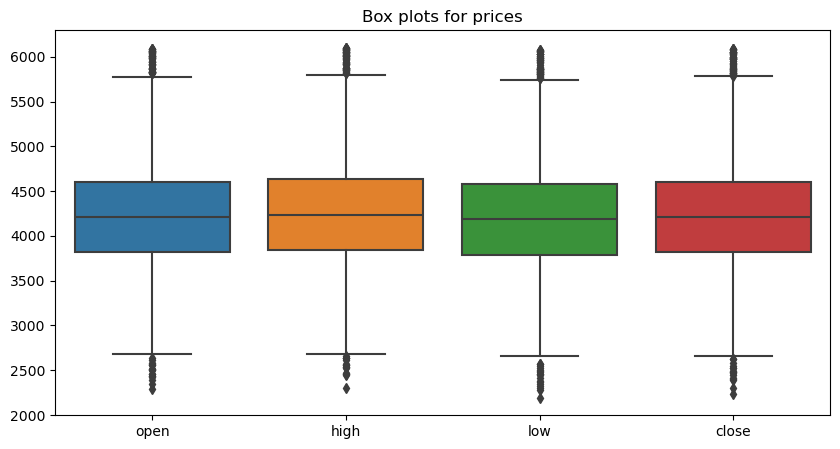

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['open', 'high', 'low', 'close']])
plt.title('Box plots for prices')
plt.show()

In [14]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

price_columns = ['open', 'high', 'low', 'close']
outliers_count = {col: count_outliers(df[col]) for col in price_columns}
print(outliers_count)

{'open': 69, 'high': 68, 'low': 71, 'close': 70}


c:\Users\santi\anaconda3\Lib\site-packages\seaborn\categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


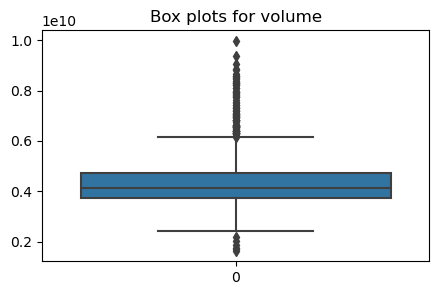

In [11]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=df['volume'])
plt.title('Box plots for volume')
plt.show()

In [15]:
outliers_count = count_outliers(df['volume'])
print(outliers_count)

92


In [12]:
df['sma_50'] = df['close'].rolling(window=50).mean()
df['sma_200'] = df['close'].rolling(window=200).mean()

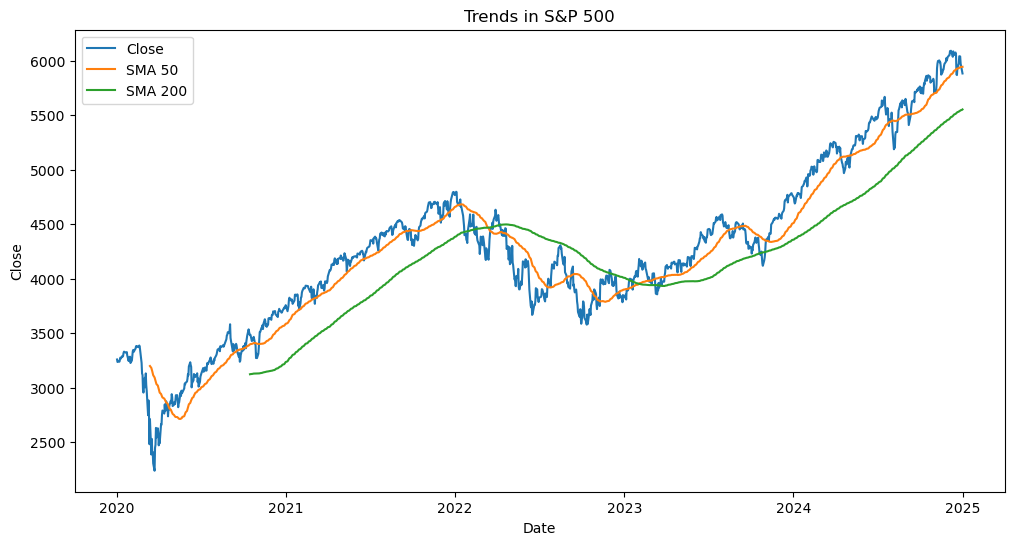

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Close')
plt.plot(df['sma_50'], label='SMA 50')
plt.plot(df['sma_200'], label='SMA 200')
plt.title('Trends in S&P 500')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [19]:
correlation = df.corr()
print(correlation)

            close      high       low      open    volume    sma_50   sma_200
close    1.000000  0.999351  0.999472  0.998775 -0.403355  0.975409  0.859627
high     0.999351  1.000000  0.999235  0.999569 -0.393526  0.978249  0.865938
low      0.999472  0.999235  1.000000  0.999357 -0.410641  0.973295  0.854410
open     0.998775  0.999569  0.999357  1.000000 -0.399236  0.976145  0.860897
volume  -0.403355 -0.393526 -0.410641 -0.399236  1.000000 -0.356266 -0.215160
sma_50   0.975409  0.978249  0.973295  0.976145 -0.356266  1.000000  0.919175
sma_200  0.859627  0.865938  0.854410  0.860897 -0.215160  0.919175  1.000000


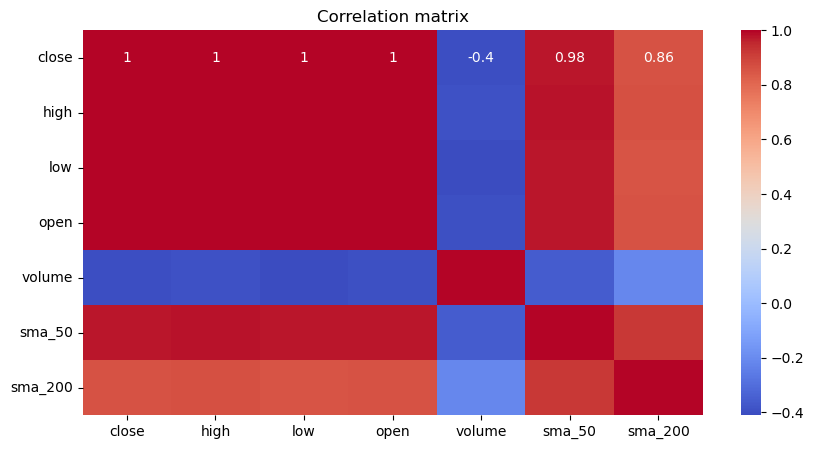

In [20]:
plt.figure(figsize=(10, 5))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [26]:
df['daily_return'] = df['close'].pct_change()
diary_volatility = df['daily_return'].std()
monthly_volatility = diary_volatility * np.sqrt(21)
df['rolling_volatility'] = df['daily_return'].rolling(window=21).std() * np.sqrt(21)

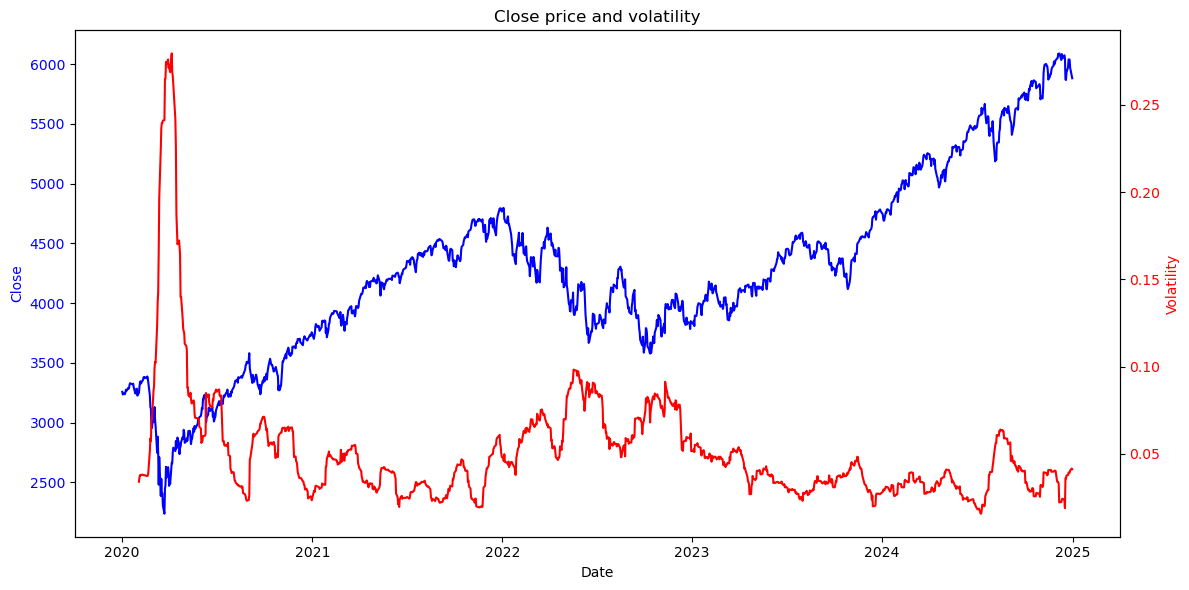

In [27]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df.index, df['close'], color='blue', label='Close')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['rolling_volatility'], color='red', label='Monthly volatility')
ax2.set_ylabel('Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Close price and volatility')
fig.tight_layout()
plt.show()

In [30]:
df['signal'] = 0
df.loc[df['sma_50'] > df['sma_200'], 'signal'] = 1
df['signal_shift'] = df['signal'].shift(1)
df['golden_cross'] = np.where((df['signal'] == 1) & (df['signal_shift'] == 0), 1, 0)
df['death_cross'] = np.where((df['signal'] == 0) & (df['signal_shift'] == 1), 1, 0)
df.drop('signal_shift', axis=1, inplace=True)
golden_cross_dates = df.loc[df['golden_cross'] == 1].index
death_cross_dates = df.loc[df['death_cross'] == 1].index

In [31]:
print(f'Golden cross dates: {golden_cross_dates}')
print(f'Death cross dates: {death_cross_dates}')

Golden cross dates: DatetimeIndex(['2020-10-15', '2023-02-02'], dtype='datetime64[ns]', name='date', freq=None)
Death cross dates: DatetimeIndex(['2022-03-14'], dtype='datetime64[ns]', name='date', freq=None)


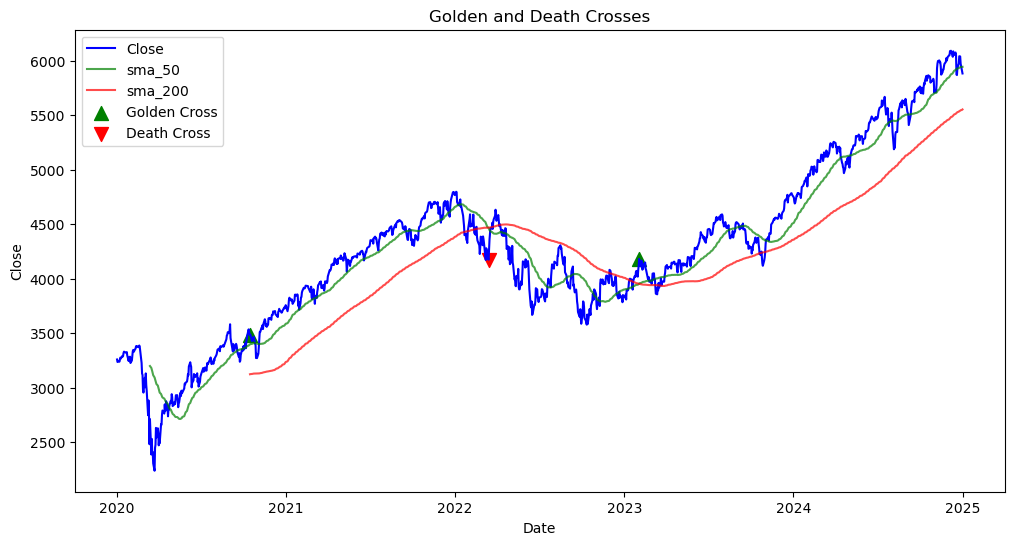

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Close', color='blue')
plt.plot(df.index, df['sma_50'], label='sma_50', color='green', alpha=0.7)
plt.plot(df.index, df['sma_200'], label='sma_200', color='red', alpha=0.7)

plt.scatter(df.loc[df['golden_cross'] == 1].index,
            df.loc[df['golden_cross'] == 1, 'close'],
            marker='^', color='green', label='Golden Cross', s=100)

plt.scatter(df.loc[df['death_cross'] == 1].index,
            df.loc[df['death_cross'] == 1, 'close'],
            marker='v', color='red', label='Death Cross', s=100)

plt.title('Golden and Death Crosses')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

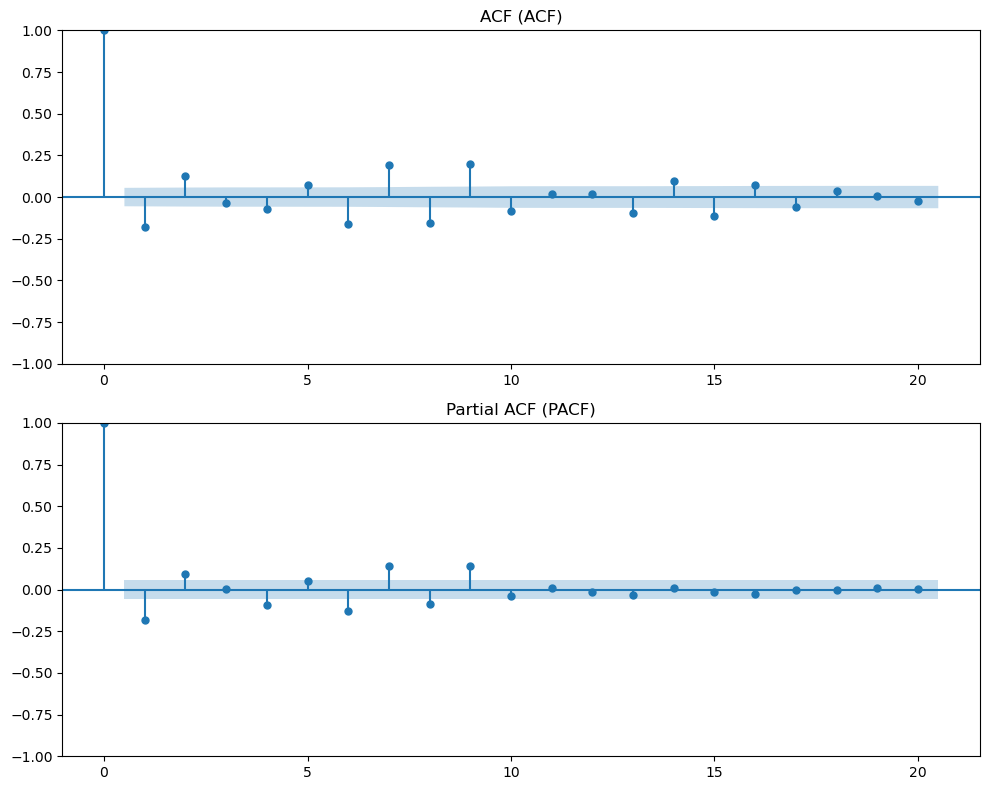

In [35]:
df['returns'] = df['close'].pct_change()
serie = df['returns'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(serie, lags=20, ax=axes[0], title="ACF (ACF)")
plot_pacf(serie, lags=20, ax=axes[1], title="Partial ACF (PACF)")
plt.tight_layout()
plt.show()

In [37]:
test_result = acorr_ljungbox(serie, lags=[1,2,3,4,5,6,7,8,9,10], return_df=True)
print(test_result)

       lb_stat     lb_pvalue
1    41.531310  1.159982e-10
2    61.203629  5.126263e-14
3    62.895959  1.413562e-13
4    68.863107  3.944178e-14
5    75.497578  7.324327e-15
6   107.911606  5.577419e-21
7   155.526732  2.800049e-30
8   185.440779  7.405373e-36
9   233.981843  2.384799e-45
10  242.982903  1.619274e-46


In [38]:
Q1 = df['returns'].quantile(0.25)
Q3 = df['returns'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['outlier'] = (df['returns'] < lower_bound) | (df['returns'] > upper_bound)

In [39]:
stats = df['returns'].describe()
df_no_outliers = df[~df['outlier']]
stats_without_outliers = df_no_outliers['returns'].describe()

print('Stats with outliers', stats)
print('Stats without outliers', stats_without_outliers)

Stats with outliers count    1257.000000
mean        0.000561
std         0.013443
min        -0.119841
25%        -0.005307
50%         0.000888
75%         0.007266
max         0.093828
Name: returns, dtype: float64
Stats without outliers count    1192.000000
mean        0.001106
std         0.009117
min        -0.023799
25%        -0.004407
50%         0.001012
75%         0.007090
max         0.025966
Name: returns, dtype: float64


In [ ]:
df['rolling_vol'] = df['returns'].rolling(window=21).std() * np.sqrt(252)
threshold = df['rolling_vol'].median()
df['regime'] = np.where(df['rolling_vol'] > threshold, 'High Volatility', 'Low Volatility')

regime
Low Volatility     640
High Volatility    618
Name: count, dtype: int64

In [49]:
high_vol = df[df['regime'] == 'High Volatility']
low_vol = df[df['regime'] == 'Low Volatility']

print("Statistics of returns in high volatility:")
print(high_vol['returns'].describe())
print("\nStatistics of returns in high volatility:")
print(low_vol['returns'].describe())

Statistics of returns in high volatility:
count    618.000000
mean       0.000339
std        0.017760
min       -0.119841
25%       -0.008112
50%        0.000564
75%        0.010546
max        0.093828
Name: returns, dtype: float64

Statistics of returns in high volatility:
count    639.000000
mean       0.000776
std        0.007115
min       -0.029493
25%       -0.003033
50%        0.000969
75%        0.005562
max        0.025296
Name: returns, dtype: float64


In [50]:
df['returns_scaled'] = df['returns'] * 100
garch_model = arch_model(df['returns_scaled'].dropna(), vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(update_freq=5)
print(garch_fit.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 2329.774859160273
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1832.9535480097938
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1832.9535480097938
            Iterations: 11
            Function evaluations: 64
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:         returns_scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1832.95
Distribution:                  Normal   AIC:                           3673.91
Method:            Maximum Likelihood   BIC:                           3694.45
                                        No. Observations:                 1257
Date:                Wed, Feb 26 2025   Df Residuals:                     1256
Time:        

In [51]:
egarch_model = arch_model(df['returns_scaled'].dropna(), vol='EGarch', p=1, q=1)
egarch_fit = egarch_model.fit(update_freq=5)
print(egarch_fit.summary())

Iteration:      5,   Func. Count:     39,   Neg. LLF: 1838.5640460217467
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1838.5164784771569
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1838.5164784771569
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         returns_scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1838.52
Distribution:                  Normal   AIC:                           3685.03
Method:            Maximum Likelihood   BIC:                           3705.58
                                        No. Observations:                 1257
Date:                Wed, Feb 26 2025   Df Residuals:                     1256
Time:       

c:\Users\santi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\santi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


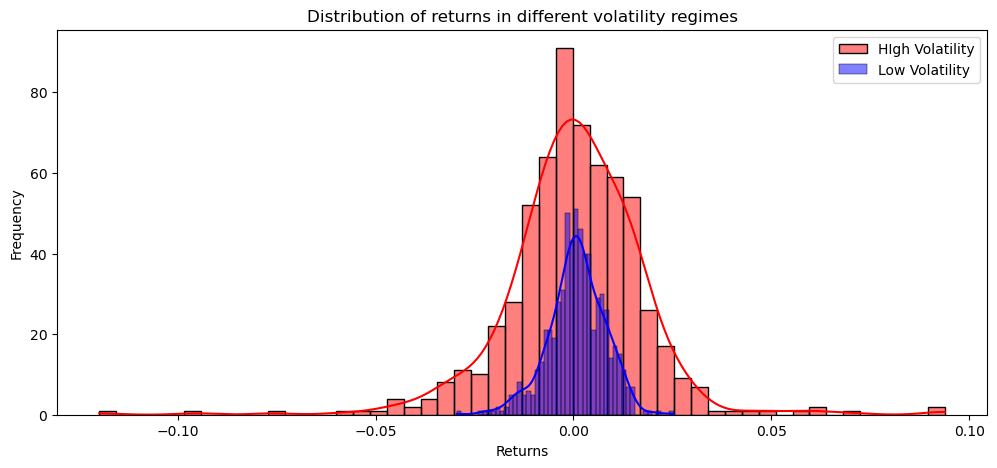

In [52]:
plt.figure(figsize=(12,5))
sns.histplot(df[df['regime'] == 'High Volatility']['returns'], bins=50, color='red', label='HIgh Volatility', kde=True)
sns.histplot(df[df['regime'] == 'Low Volatility']['returns'], bins=50, color='blue', label='Low Volatility', kde=True)
plt.title('Distribution of returns in different volatility regimes')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

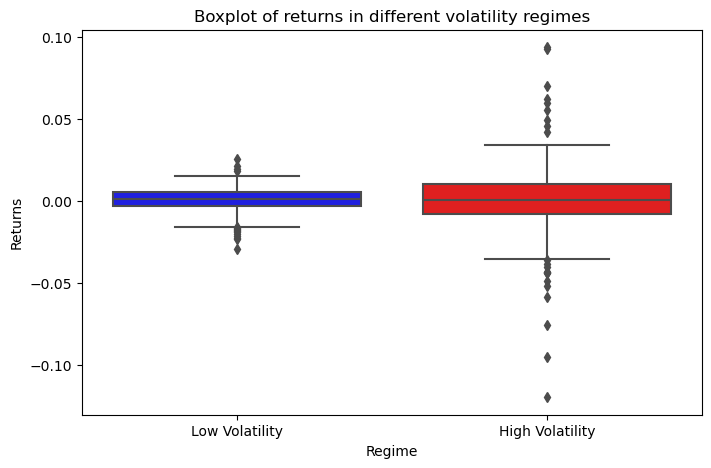

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df['regime'], y=df['returns'], palette={'High Volatility': 'red', 'Low Volatility': 'blue'})
plt.title('Boxplot of returns in different volatility regimes')
plt.xlabel('Regime')
plt.ylabel('Returns')
plt.show()

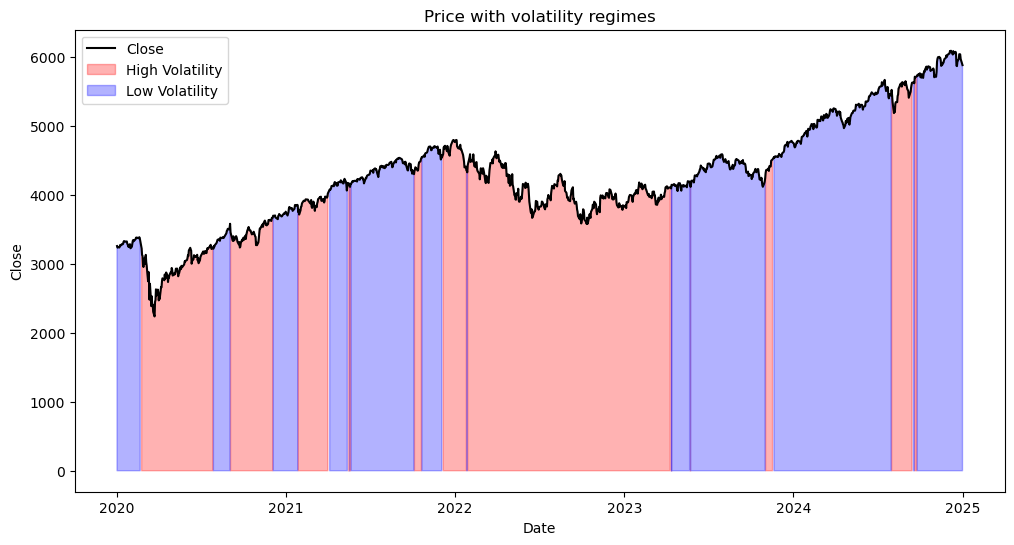

In [60]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['close'], color='black', label='Close')

plt.fill_between(df.index, df['close'], 
                 where=(df['regime'] == 'High Volatility'), 
                 color='red', alpha=0.3, label='High Volatility')

plt.fill_between(df.index, df['close'], 
                 where=(df['regime'] == 'Low Volatility'), 
                 color='blue', alpha=0.3, label='Low Volatility')

plt.title('Price with volatility regimes')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


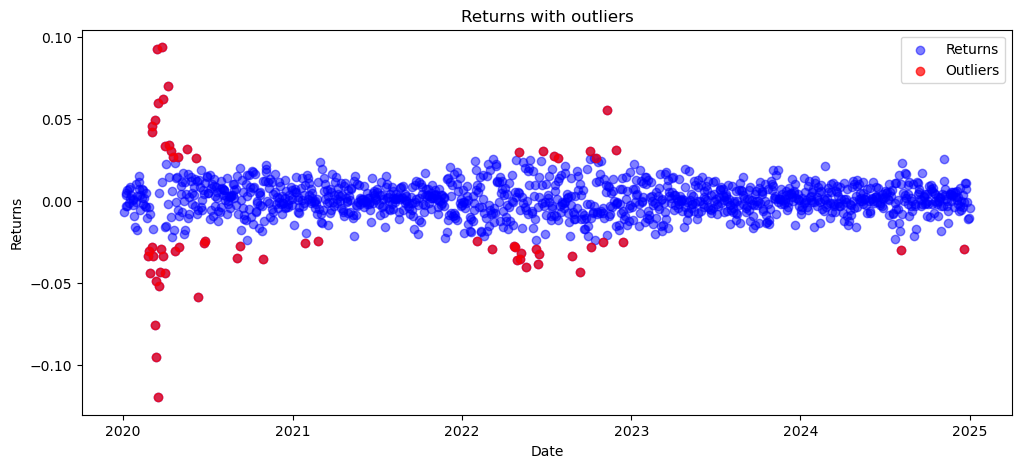

In [61]:
plt.figure(figsize=(12,5))
plt.scatter(df.index, df['returns'], label='Returns', color='blue', alpha=0.5)
plt.scatter(df[df['outlier']].index, df[df['outlier']]['returns'], color='red', label='Outliers', alpha=0.7)
plt.title('Returns with outliers')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [ ]:
df_clean = df[~df['outlier']]

print("Stats with outliers:")
print(df['returns'].describe())

print("\nStats without outliers:")
print(df_clean['returns'].describe())

Stats with outliers:
count    1257.000000
mean        0.000561
std         0.013443
min        -0.119841
25%        -0.005307
50%         0.000888
75%         0.007266
max         0.093828
Name: returns, dtype: float64

Stats without outliers:
count    1192.000000
mean        0.001106
std         0.009117
min        -0.023799
25%        -0.004407
50%         0.001012
75%         0.007090
max         0.025966
Name: returns, dtype: float64


In [63]:
df_clean['returns_scaled'] = df_clean['returns'] * 100
garch_model = arch_model(df_clean['returns_scaled'].dropna(), vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(update_freq=5)
print(garch_fit.summary())

Iteration:      5,   Func. Count:     36,   Neg. LLF: 2127.9553142956697
Iteration:     10,   Func. Count:     63,   Neg. LLF: 1532.7672297365045
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1532.7672290665678
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:         returns_scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1532.77
Distribution:                  Normal   AIC:                           3073.53
Method:            Maximum Likelihood   BIC:                           3093.87
                                        No. Observations:                 1192
Date:                Wed, Feb 26 2025   Df Residuals:                     1191
Time:       

C:\Users\santi\AppData\Local\Temp\ipykernel_16756\71245762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['returns_scaled'] = df_clean['returns'] * 100


In [64]:
egarch_model = arch_model(df_clean['returns_scaled'].dropna(), vol='EGarch', p=1, q=1)
egarch_fit = egarch_model.fit(update_freq=5)
print(egarch_fit.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 8979.828669223596
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1534.762972866775
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1534.762972866775
            Iterations: 11
            Function evaluations: 70
            Gradient evaluations: 11
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         returns_scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1534.76
Distribution:                  Normal   AIC:                           3077.53
Method:            Maximum Likelihood   BIC:                           3097.86
                                        No. Observations:                 1192
Date:                Wed, Feb 26 2025   Df Residuals:                     1191
Time:          

## With outliers

In [ ]:
garch_model_t = arch_model(df['returns_scaled'].dropna(), vol='Garch', p=1, q=1, dist='t')
garch_fit_t = garch_model_t.fit(update_freq=5)
print(garch_fit_t.summary())

egarch_model_t = arch_model(df['returns_scaled'].dropna(), vol='EGarch', p=1, q=1, dist='t')
egarch_fit_t = egarch_model_t.fit(update_freq=5)
print(egarch_fit_t.summary())

Iteration:      5,   Func. Count:     39,   Neg. LLF: 1813.7312373299937
Iteration:     10,   Func. Count:     72,   Neg. LLF: 1809.0980104381274
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1809.0980097606816
            Iterations: 11
            Function evaluations: 78
            Gradient evaluations: 11
                        Constant Mean - GARCH Model Results                         
Dep. Variable:               returns_scaled   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1809.10
Distribution:      Standardized Student's t   AIC:                           3628.20
Method:                  Maximum Likelihood   BIC:                           3653.88
                                              No. Observations:                 1257
Date:                      Wed, Feb 26 2025   Df 

## Without outliers

In [66]:
garch_model_clean_t = arch_model(df_clean['returns_scaled'].dropna(), vol='Garch', p=1, q=1, dist='t')
garch_fit_clean_t = garch_model_clean_t.fit(update_freq=5)
print(garch_fit_clean_t.summary())

egarch_model_clean_t = arch_model(df_clean['returns_scaled'].dropna(), vol='EGarch', p=1, q=1, dist='t')
egarch_fit_clean_t = egarch_model_clean_t.fit(update_freq=5)
print(egarch_fit_clean_t.summary())

Iteration:      5,   Func. Count:     44,   Neg. LLF: 1546.668742290852
Iteration:     10,   Func. Count:     75,   Neg. LLF: 1533.043434944092
Iteration:     15,   Func. Count:    105,   Neg. LLF: 1532.671853920427
Iteration:     20,   Func. Count:    147,   Neg. LLF: 1532.6670328383516
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1532.6670286994754
            Iterations: 22
            Function evaluations: 169
            Gradient evaluations: 22
                        Constant Mean - GARCH Model Results                         
Dep. Variable:               returns_scaled   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1532.67
Distribution:      Standardized Student's t   AIC:                           3075.33
Method:                  Maximum Likelihood   BIC:                         

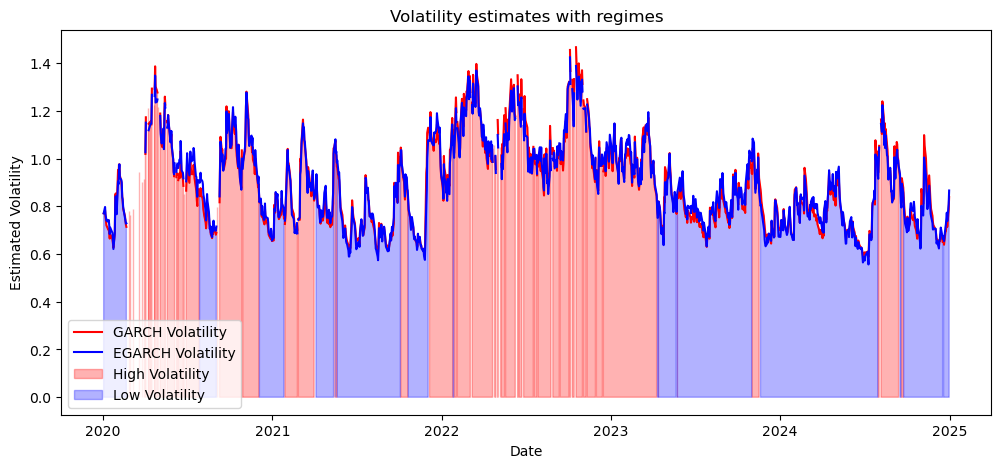

In [ ]:
df['garch_vol'] = garch_fit.conditional_volatility
df['egarch_vol'] = egarch_fit.conditional_volatility

plt.figure(figsize=(12,5))
plt.plot(df.index, df['garch_vol'], label='GARCH Volatility', color='red')
plt.plot(df.index, df['egarch_vol'], label='EGARCH Volatility', color='blue')
plt.fill_between(df.index, df['garch_vol'], 
                 where=(df['regime'] == 'High Volatility'), 
                 color='red', alpha=0.3, label='High Volatility')

plt.fill_between(df.index, df['garch_vol'], 
                 where=(df['regime'] == 'Low Volatility'), 
                 color='blue', alpha=0.3, label='Low Volatility')

plt.title('Volatility estimates with regimes')
plt.xlabel('Date')
plt.ylabel('Estimated Volatility')
plt.legend()
plt.show()

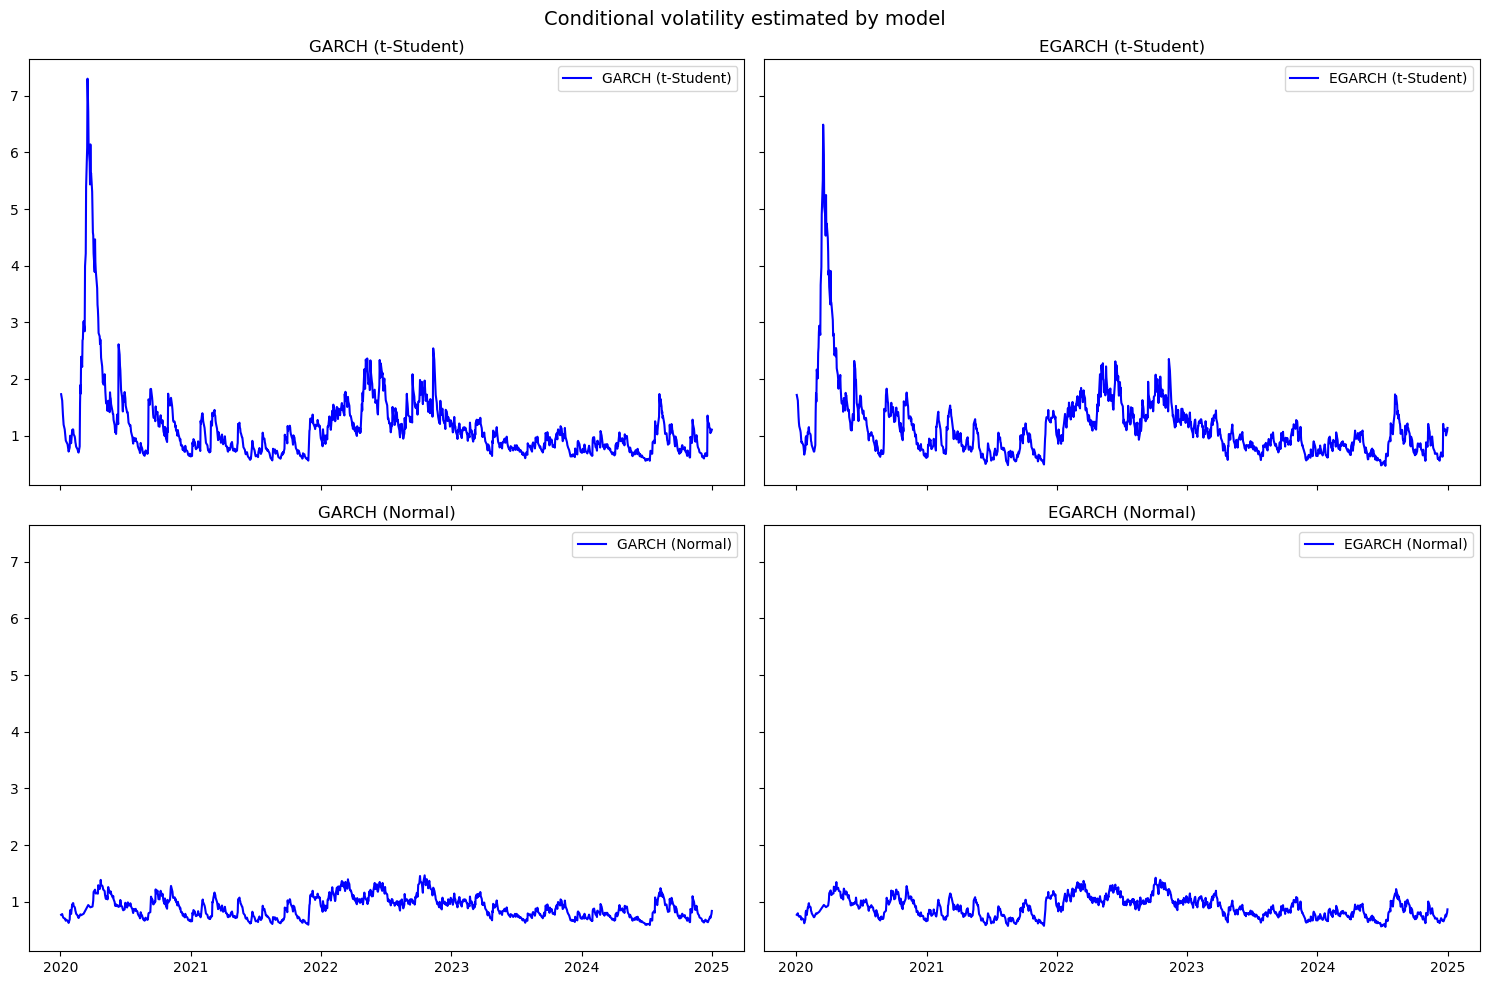

c:\Users\santi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\santi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\santi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\santi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

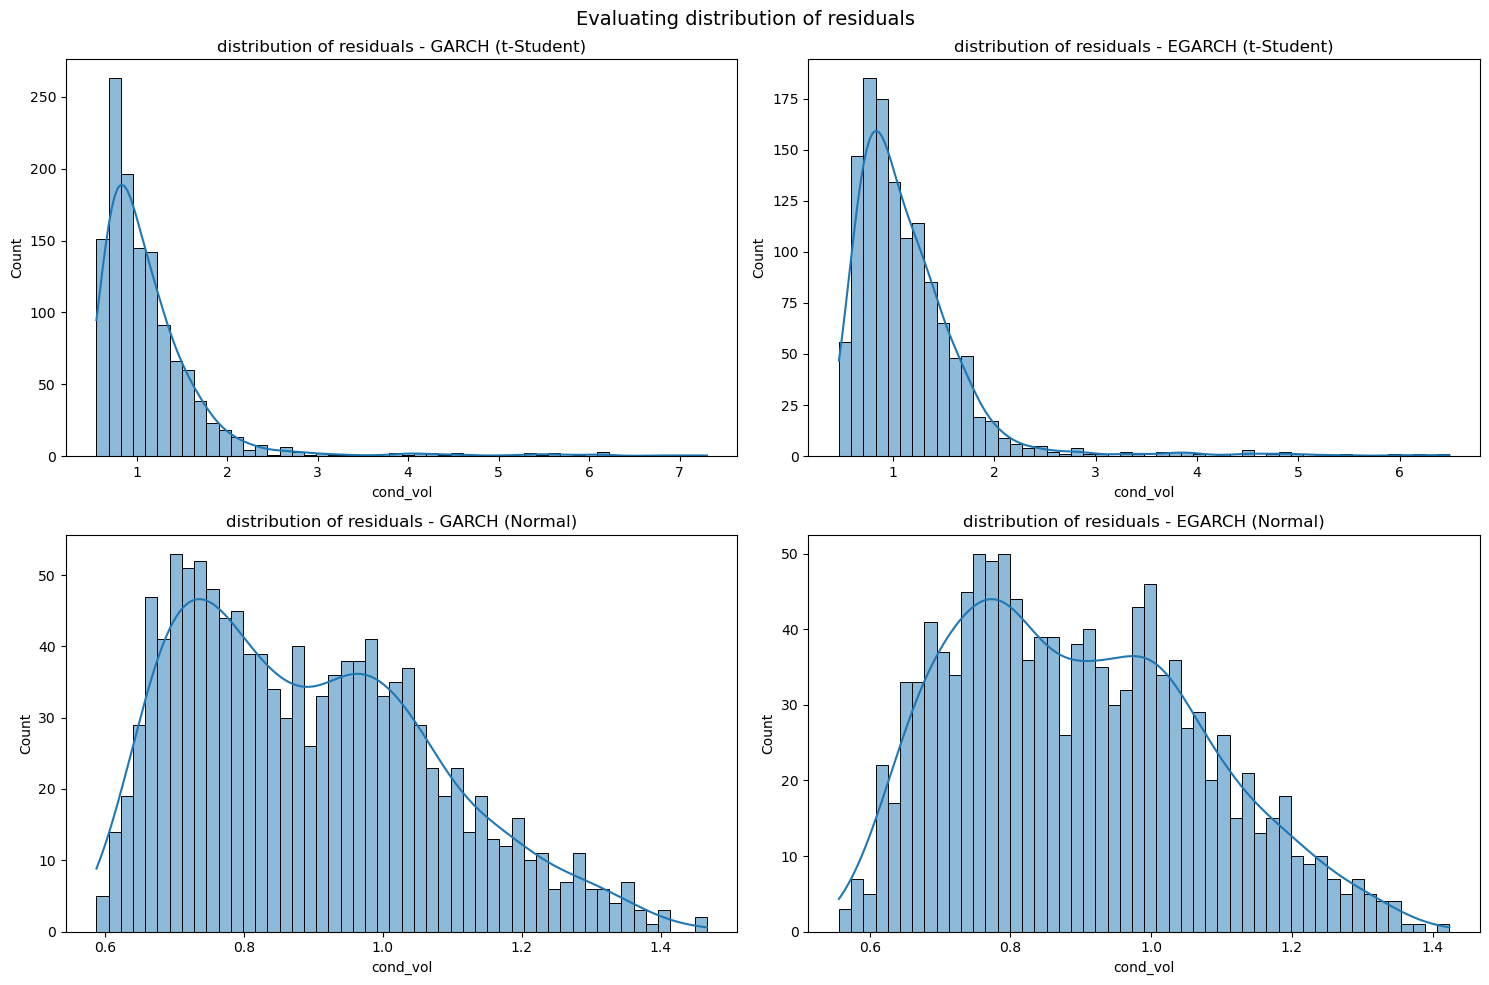

({'GARCH (t-Student)': 1.6192741252409727e-46,
  'EGARCH (t-Student)': 1.6192741252410194e-46,
  'GARCH (Normal)': 0.46296066893356813,
  'EGARCH (Normal)': 0.46296066893356813},
 {'GARCH (t-Student)': 6.797923906080192e-104,
  'EGARCH (t-Student)': 6.824666515307755e-104,
  'GARCH (Normal)': 1.8037814730171516e-18,
  'EGARCH (Normal)': 1.8038606721766172e-18})

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

model_names = ["GARCH (t-Student)", "EGARCH (t-Student)", "GARCH (Normal)", "EGARCH (Normal)"]
volatility_series = [garch_fit_t.conditional_volatility, egarch_fit_t.conditional_volatility,
                     garch_fit.conditional_volatility, egarch_fit.conditional_volatility]


for i, ax in enumerate(ax.flatten()):
    ax.plot(volatility_series[i], label=model_names[i], color="b")
    ax.set_title(model_names[i])
    ax.legend()


plt.suptitle("Conditional volatility estimated by model", fontsize=14)
plt.tight_layout()
plt.show()

# Evaluating autocorrelation with Ljung-Box test (p-value)
lb_test = {name: acorr_ljungbox(resid, lags=[10], return_df=True)["lb_pvalue"].values[0] 
           for name, resid in zip(model_names, [garch_fit_t.resid, egarch_fit_t.resid, garch_fit.resid, egarch_fit.resid])}

# Test ARCH for heteroscedasticity in the residuals
arch_test = {name: het_arch(resid)[1]  # p-value
             for name, resid in zip(model_names, [garch_fit_t.resid, egarch_fit_t.resid, garch_fit.resid, egarch_fit.resid])}

# Visualizing the distribution of residuals
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, ax in enumerate(ax.flatten()):
    sns.histplot(volatility_series[i], bins=50, kde=True, ax=ax)
    ax.set_title(f"distribution of residuals - {model_names[i]}")

plt.suptitle("Evaluating distribution of residuals", fontsize=14)
plt.tight_layout()
plt.show()

(lb_test, arch_test)


In [72]:
df.columns

Index(['close', 'high', 'low', 'open', 'volume', 'sma_50', 'sma_200',
       'daily_return', 'rolling_volatility', 'signal', 'golden_cross',
       'death_cross', 'returns', 'outlier', 'rolling_vol', 'regime',
       'returns_scaled', 'garch_vol', 'egarch_vol'],
      dtype='object')

In [74]:
df_raw = pd.read_csv('../data/raw_data/gspc.csv', index_col='date')
df_raw.index = pd.to_datetime(df_raw.index)

In [79]:
df_raw.drop(df_raw.index[0], inplace=True)

In [85]:
df_raw = df_raw.astype(float)

In [ ]:
selected_features = [
    'close', 'high', 'low', 'open', 'volume',
    'sma_50', 'sma_200',
    'daily_return', 'rolling_volatility', 'rolling_vol', 'returns',
    'egarch_vol'
]

In [89]:
df_features = df[selected_features].copy()

In [94]:
df_features.to_csv('../data/processed_data/gspc.csv', index=True)